In [ ]:
# Установка библиотеки opendatasets для удобной загрузки датасетов с кагла
%pip install opendatasets

In [ ]:
# Импорт библиотеки opendatasets для загрузки datasets
import opendatasets as op

# Загрузка dataset "COVID-19 Radiography Database" с Kaggle
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

In [ ]:
# Установка библиотек для работы с глубоким обучением и обработкой изображений
%pip install tensorflow keras matplotlib opencv-python

In [ ]:
# Импорт необходимых библиотек
import os  # Для работы с файловой системой
import numpy as np  # Для работы с массивами и математическими операциями
import cv2  # Для обработки изображений
import matplotlib.pyplot as plt  # Для визуализации данных
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate  # Слои для построения модели
from tensorflow.keras.models import Model  # Класс для создания модели
from sklearn.model_selection import train_test_split  # Для разделения данных на обучающую и тестовую выборки
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Для загрузки и преобразования изображений

In [ ]:
# Пути к директориям с изображениями и масками
image_dir = "./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
mask_dir = "./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"

# Параметры изображений
IMG_HEIGHT = 128  # Высота изображения
IMG_WIDTH = 128  # Ширина изображения
IMG_CHANNELS = 1  # Количество каналов (1 для черно-белых изображений)

# Функция для загрузки изображений и масок
def load_images(image_dir, mask_dir):
    images = []  # Список для хранения изображений
    masks = []  # Список для хранения масок

    # Получение списка файлов в директориях
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    # Цикл по всем файлам
    for image_file, mask_file in zip(image_files, mask_files):
        # Загрузка изображения
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)  # Чтение в grayscale
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))  # Изменение размера
        image = img_to_array(image) / 255.0  # Преобразование в массив и нормализация

        # Загрузка маски
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)  # Чтение в grayscale
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))  # Изменение размера
        mask = img_to_array(mask) / 255.0  # Преобразование в массив и нормализация

        # Добавление изображения и маски в списки
        images.append(image)
        masks.append(mask)

    # Преобразование списков в массивы numpy
    return np.array(images), np.array(masks)

# Загрузка изображений и масок
images, masks = load_images(image_dir, mask_dir)

In [ ]:
# Функция для создания модели U-Net
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    # Входной слой
    inputs = Input(input_size)

    # Энкодер (сжатие)
    # Первый блок свёрток
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Первая свёртка
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)  # Вторая свёртка
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Подвыборка (пулинг)

    # Второй блок свёрток
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Третий блок свёрток
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Бутылочное горлышко (bottleneck)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Декодер (расширение)
    # Первый блок апсемплинга
    up5 = UpSampling2D(size=(2, 2))(conv4)  # Увеличение размерности
    up5 = concatenate([up5, conv3], axis=3)  # Соединение с соответствующим слоем энкодера
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    # Второй блок апсемплинга
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    # Третий блок апсемплинга
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Выходной слой
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)  # Свёртка 1x1 для получения маски

    # Создание модели
    model = Model(inputs=[inputs], outputs=[outputs])

    # Компиляция модели
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Инициализация модели
model = unet_model()
model.summary()  # Вывод структуры модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 64, 64, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Разделение на обучающую и тестовую выборку
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Обучение модели
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step


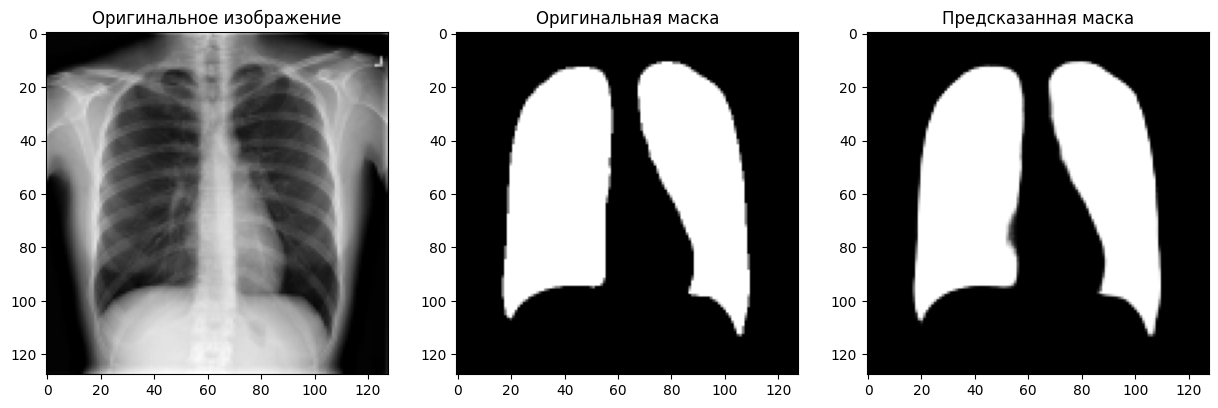

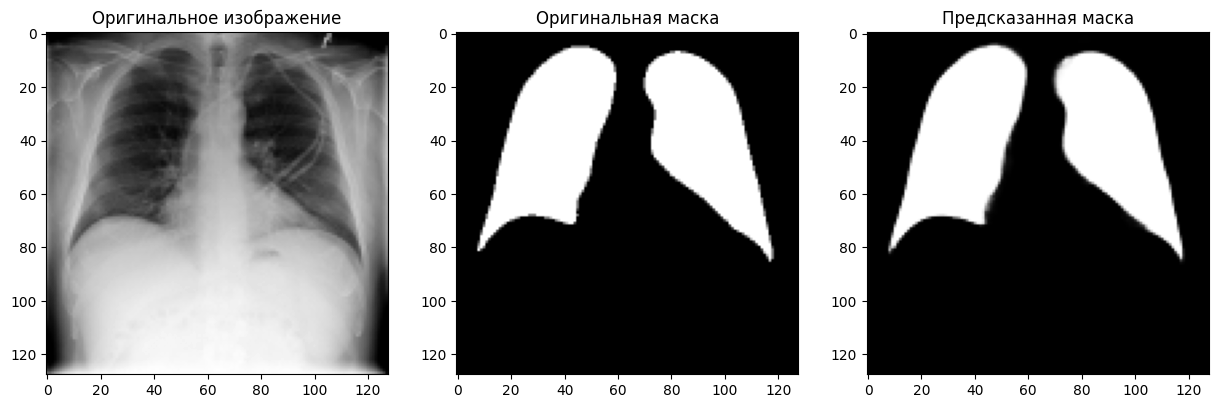

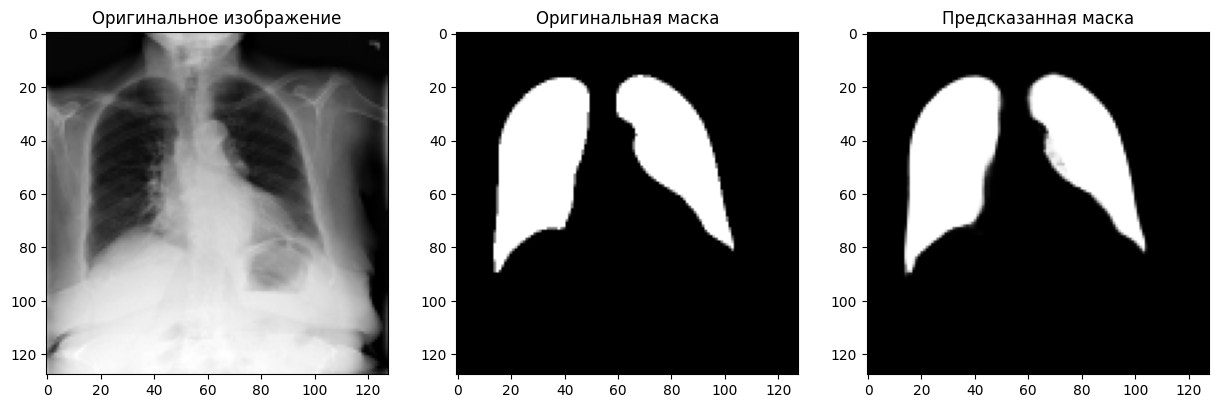

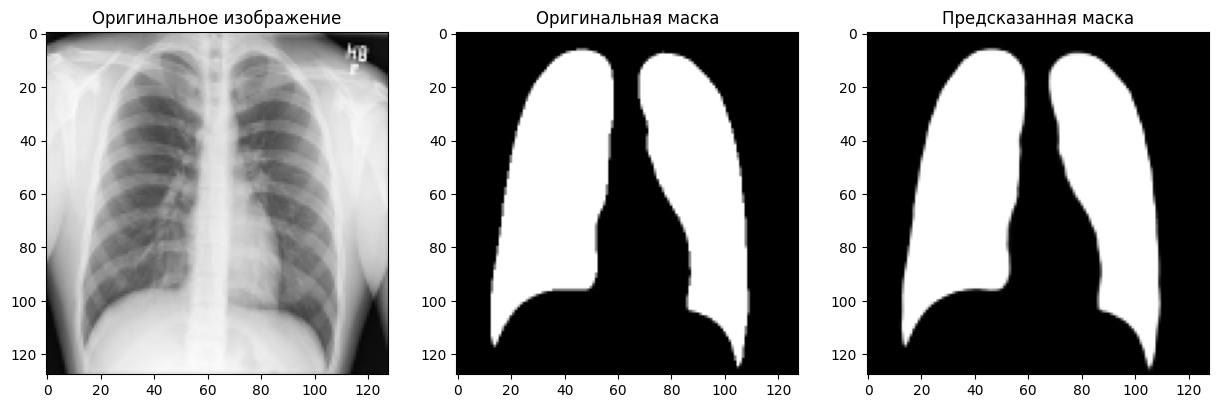

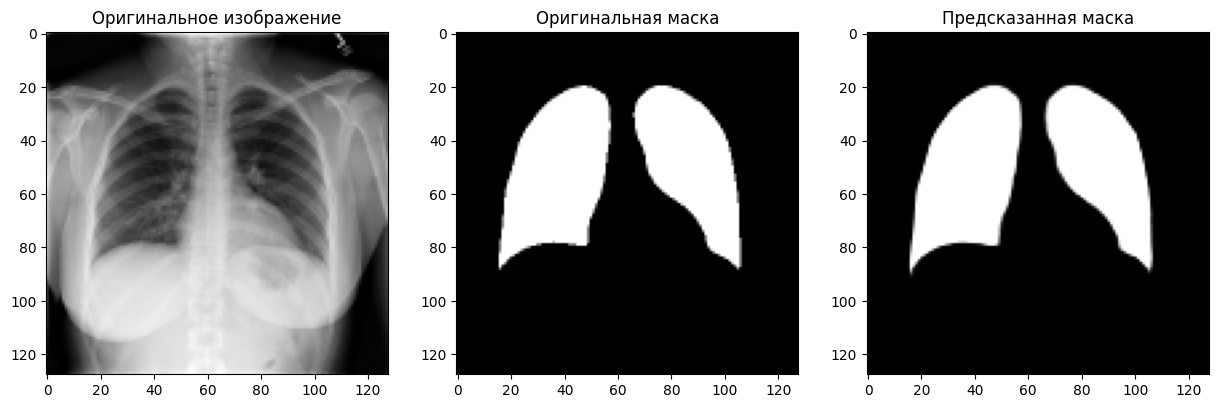

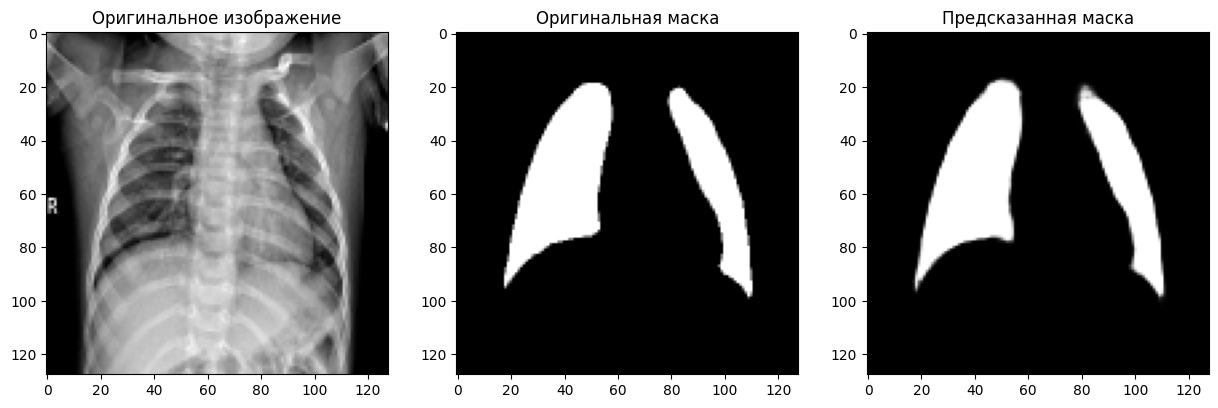

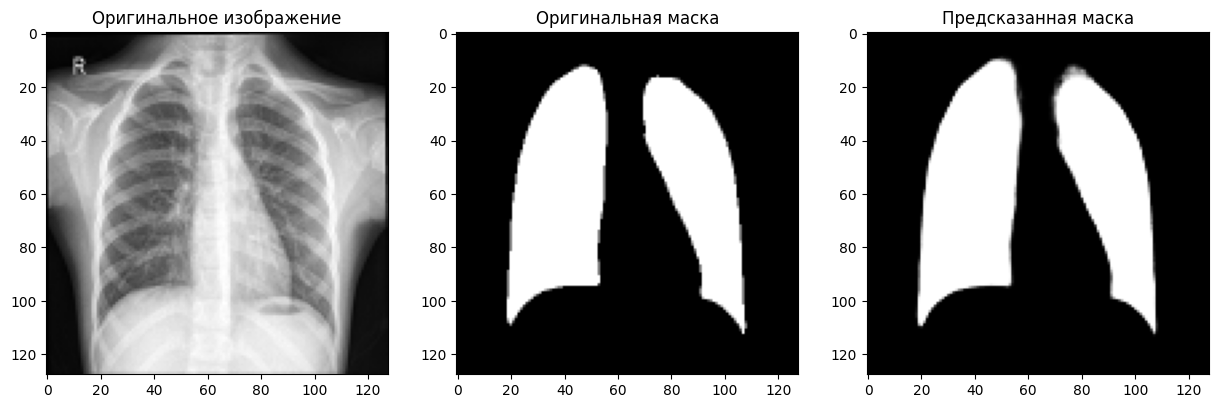

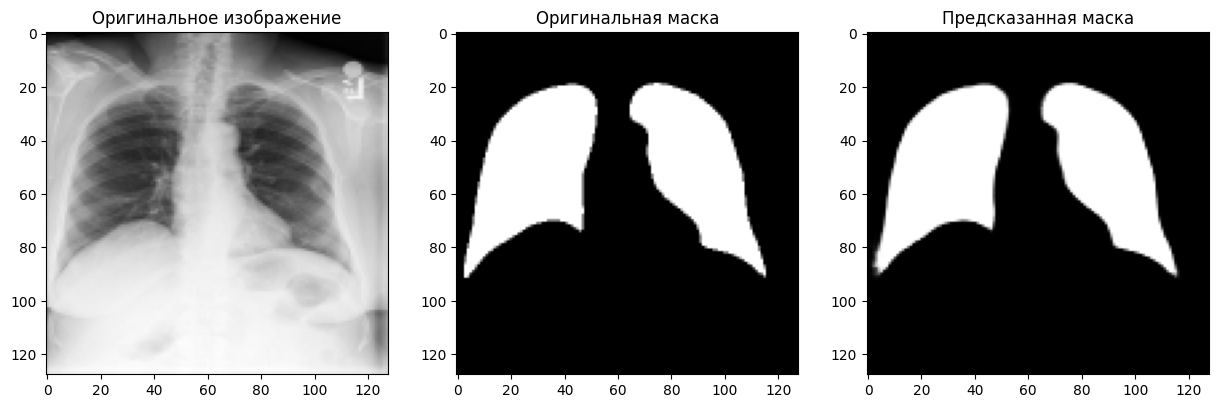

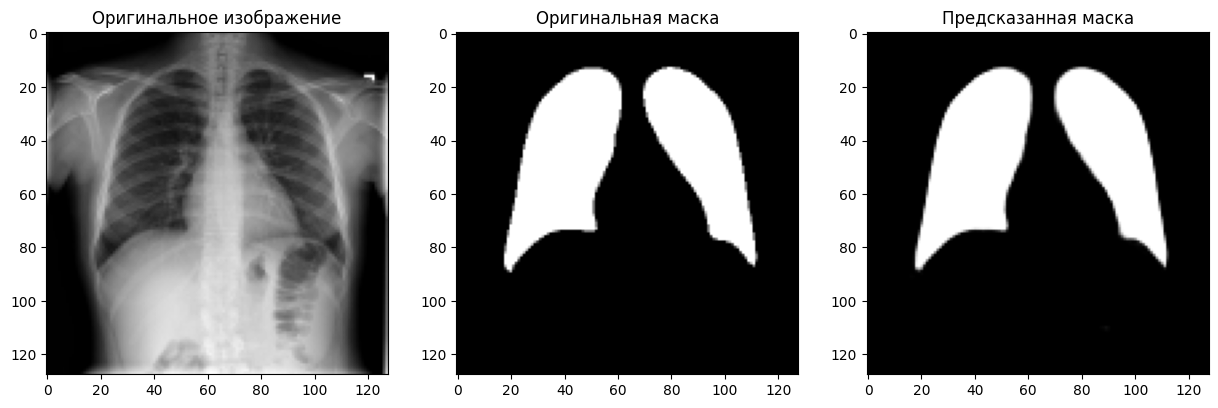

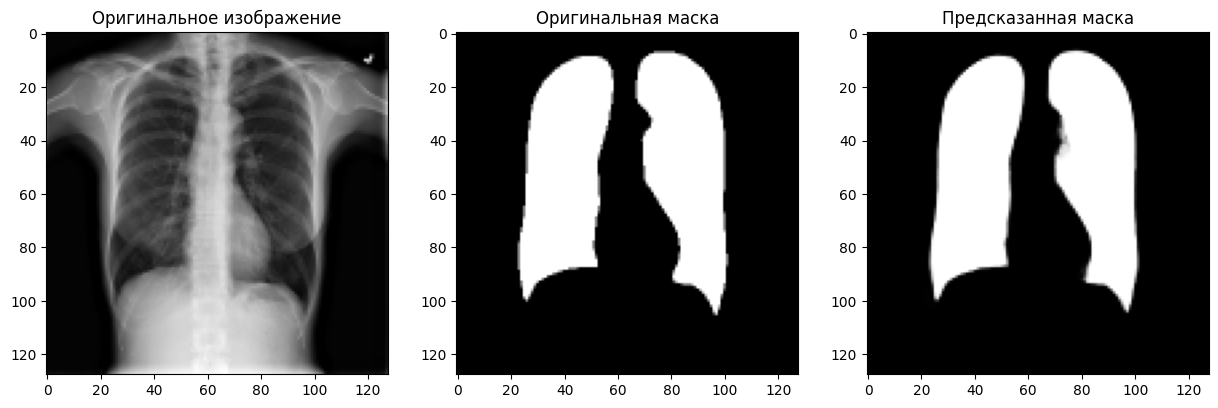

In [ ]:
# Функция для визуализации оригинальных изображений, масок и предсказаний
def plot_predictions(images, masks, predictions, num_images=10):
    for i in range(num_images):  # Цикл по заданному количеству изображений
        plt.figure(figsize=(15, 5))  # Создание фигуры с заданным размером

        # Отображение оригинального изображения
        plt.subplot(1, 3, 1)  # Создание подграфика (1 строка, 3 столбца, 1-й подграфик)
        plt.title("Оригинальное изображение")  # Заголовок
        plt.imshow(images[i].squeeze(), cmap='gray')  # Отображение изображения в grayscale

        # Отображение оригинальной маски
        plt.subplot(1, 3, 2)  # 2-й подграфик
        plt.title("Оригинальная маска")  # Заголовок
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Отображение маски в grayscale

        # Отображение предсказанной маски
        plt.subplot(1, 3, 3)  # 3-й подграфик
        plt.title("Предсказанная маска")  # Заголовок
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Отображение предсказания в grayscale

        plt.show()  # Показ графика

# Получение предсказаний модели на валидационных данных
predictions = model.predict(X_val)

# Визуализация результатов
plot_predictions(X_val, y_val, predictions, num_images=10)  # Отображение 10 изображений